In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

import sklearn.naive_bayes as nb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# import my own logistic regression class
from logit import Logit

## Load and split the data

In [2]:
df = pd.read_csv("~/Projects/HW_ML/data/data-classification/haberman.data",
                 header=0,
                 )
df.columns = ["Age", "Operation year", "Positive nodes", "Survival"]

# let's fill the column with next values:
# 0 if patient died within 5 years
# 1 if patient survived
df["Survival"] = -(df["Survival"] - 2)

In [3]:
# check if there are missing numbers
# spoiler: there aren't any, rtfm for ds :)
df.isnull().sum()

Age               0
Operation year    0
Positive nodes    0
Survival          0
dtype: int64

In [4]:
X = df[["Age", "Operation year", "Positive nodes"]]
x_train, x_test, y_train, y_test = train_test_split(X, df["Survival"], train_size=.8)

## Implement summary function

 - accuracy on train set
 - accuracy on test set
 
 Since we are working with medical data,
 it's necessary to implement these:
 
 - precision: $\frac{tp}{tp+fp}$
 - fall-out: $\frac{fp}{fp+tn}$
 
 Visualization
 
 - confusion matrices

In [5]:
def summary(model,
            x_train, x_test,
            y_train, y_test):
    """
    prints accuracy for both train and test sets
    plots 4 fancy confusion matrices

    :param model: a trained classifier
    :param x_train: train set variables
    :param x_test: test set variables
    :param y_train: train set labels
    :param y_test: test set labels
    :return: None
    """
    print(f"Train set accuracy: {model.score(x_train, y_train)*100:.2f}%")
    print(f"Test set accuracy: {model.score(x_test, y_test)*100:.2f}%")
    
    confusion_train = confusion_matrix(y_train, model.predict(x_train))
    confusion_test  = confusion_matrix(y_test, model.predict(x_test))
    
    precision_train = confusion_train[0,0] / (confusion_train[0,0] + confusion_train[0,1])
    precision_test  = confusion_test[0,0] / (confusion_test[0,0] + confusion_test[0,1])
    
    fallout_train = confusion_train[0,1] / (confusion_train[0,1] + confusion_train[1,1])
    fallout_test  = confusion_test[0,1] / (confusion_test[0,1] + confusion_test[1,1])
    
    print(f"Train set precision = {precision_train:.4f}, fallout = {fallout_train:.4f}")
    print(f"Test set precision = {precision_test :.4f}, fallout = {fallout_test :.4f}")

    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
    plot_confusion_matrix(model, x_train, y_train,
                     display_labels=["Dead", "Alive"],
                     xticks_rotation="horizontal",
                     normalize=None, ax=axes[0,0])
    plot_confusion_matrix(model, x_train, y_train,
                     display_labels=["Dead", "Alive"],
                     xticks_rotation="horizontal",
                     normalize='true', ax=axes[0,1])
    plot_confusion_matrix(model, x_test, y_test,
                     display_labels=["Dead", "Alive"],
                     xticks_rotation="horizontal",
                     normalize=None, ax=axes[1,0])
    plot_confusion_matrix(model, x_test, y_test,
                     display_labels=["Dead", "Alive"],
                     xticks_rotation="horizontal",
                     normalize='true', ax=axes[1,1])
    axes[0,0].set_title("Train set - numbers")
    axes[0,1].set_title("Train set - probabilities")
    axes[1,0].set_title("Test set - numbers")
    axes[1,1].set_title("Test set - probabilities")

## Naive Bayes

In [6]:
# classic multinomial distribution
model = nb.MultinomialNB().fit(x_train, y_train)

Train set accuracy: 73.77%
Test set accuracy: 73.77%
Train set precision = 0.4638, fallout = 0.2000
Test set precision = 0.2500, fallout = 0.1765


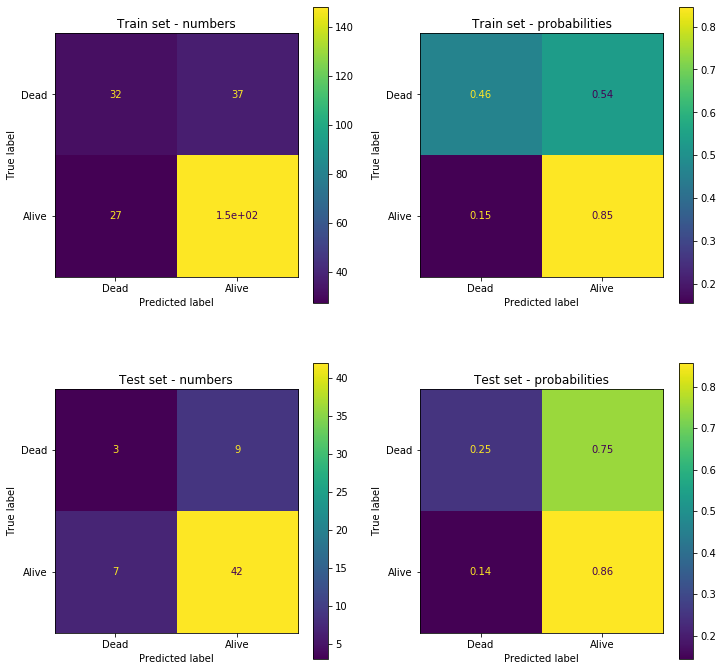

In [7]:
summary(model, x_train, x_test, y_train,y_test)

Train set accuracy: 73.77%
Test set accuracy: 72.13%
Train set precision = 0.4928, fallout = 0.1934
Test set precision = 0.2500, fallout = 0.1800


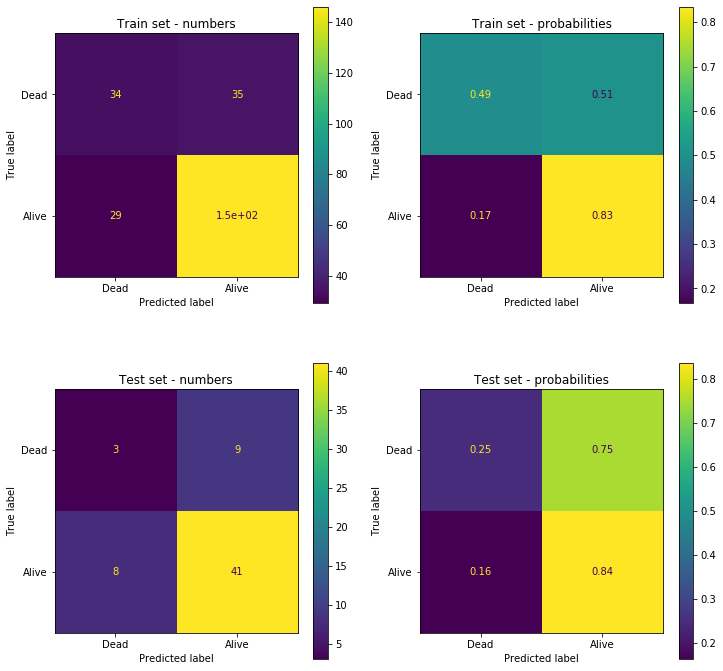

In [8]:
# trying something new!
model = nb.ComplementNB().fit(x_train,y_train)
summary(model, x_train, x_test, y_train,y_test)

Train set accuracy: 73.77%
Test set accuracy: 78.69%
Train set precision = 0.2174, fallout = 0.2466
Test set precision = 0.1667, fallout = 0.1786


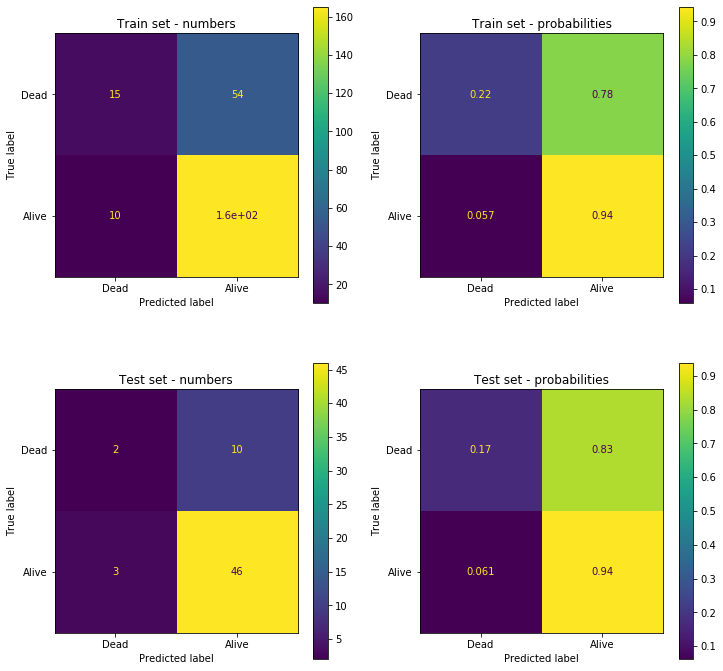

In [9]:
# this one is very positive one
model = nb.GaussianNB().fit(x_train,y_train)
summary(model, x_train, x_test, y_train,y_test)

Train set accuracy: 71.72%
Test set accuracy: 80.33%
Train set precision = 0.0000, fallout = 0.2828
Test set precision = 0.0000, fallout = 0.1967


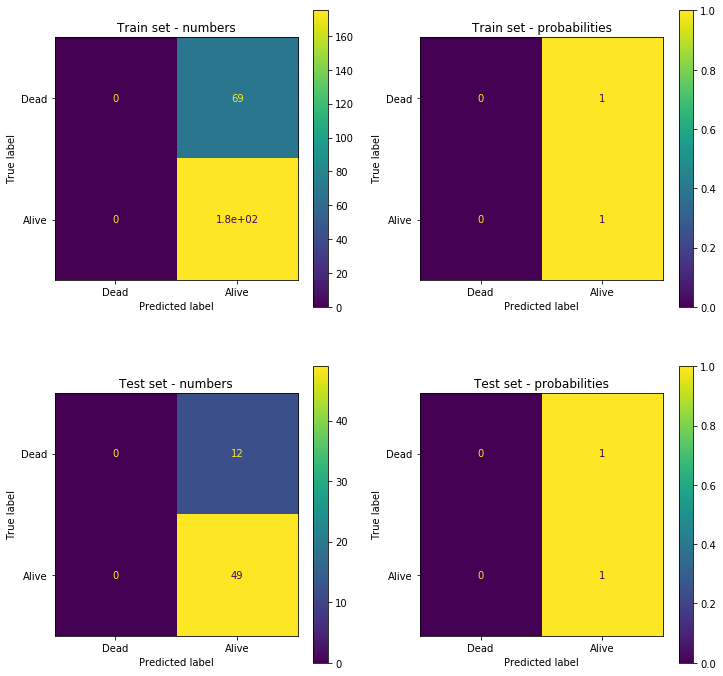

In [10]:
# this is a complete trash!
model = nb.BernoulliNB().fit(x_train,y_train)
summary(model, x_train, x_test, y_train,y_test)

## K-nearest neighbours

In [11]:
# grid search goes brr!
neighborhood = range(2, 13)
train_accuracies = []
test_accuracies = []
for n in tqdm(neighborhood, desc="Neighbours search"):
    model = KNeighborsClassifier(n_neighbors=n).fit(x_train, y_train)
    train_accuracies.append(model.score(x_train, y_train))
    test_accuracies.append(model.score(x_test, y_test))

train_accuracies = np.array(train_accuracies)
test_accuracies = np.array(test_accuracies)

Neighbours search: 100%|██████████| 11/11 [00:00<00:00, 34.94it/s]


In [12]:
best_train, train_accuracy = np.argmax(train_accuracies) + 2, np.max(train_accuracies)
best_valid, test_accuracy = np.argmax(test_accuracies) + 2, np.max(test_accuracies)

print(f"Best training accuracy {train_accuracy*100:.2f}% with {best_train} neighbours")
print(f"Best validation accuracy {test_accuracy*100:.2f}% with {best_valid} neighbours")

Best training accuracy 84.84% with 2 neighbours
Best validation accuracy 77.05% with 9 neighbours


Train set accuracy: 84.84%
Test set accuracy: 60.66%
Train set precision = 1.0000, fallout = 0.0000
Test set precision = 0.5833, fallout = 0.1429


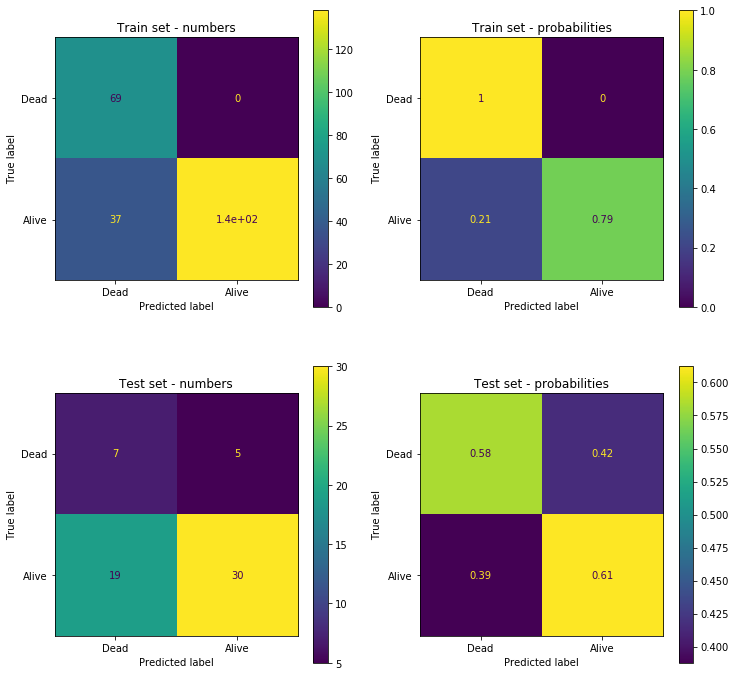

In [13]:
model = KNeighborsClassifier(n_neighbors=best_train).fit(x_train, y_train)
summary(model, x_train, x_test, y_train, y_test)

Train set accuracy: 78.28%
Test set accuracy: 77.05%
Train set precision = 0.4203, fallout = 0.1980
Test set precision = 0.2500, fallout = 0.1698


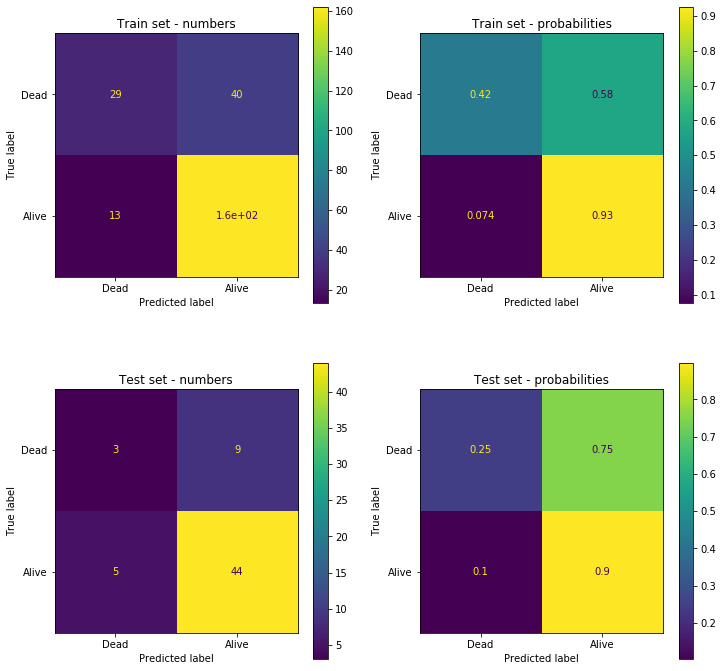

In [14]:
model = KNeighborsClassifier(n_neighbors=best_valid).fit(x_train, y_train)
summary(model, x_train, x_test, y_train, y_test)

## Logistic regression

In [15]:
model = LogisticRegression().fit(x_train, y_train)

Train set accuracy: 74.59%
Test set accuracy: 77.05%
Train set precision = 0.2174, fallout = 0.2443
Test set precision = 0.0833, fallout = 0.1930


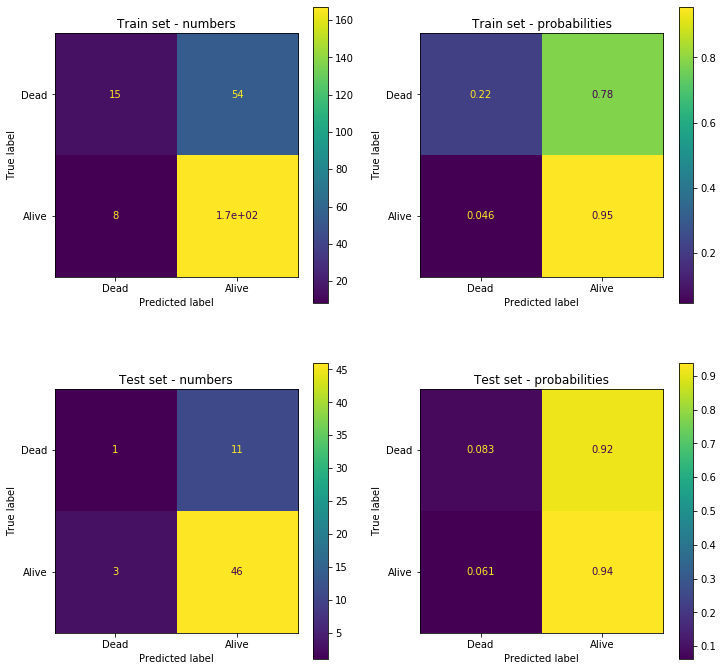

In [16]:
summary(model, x_train, x_test, y_train, y_test)

tune parameters with logit, implemented from scratch

1. Batch Gradient Descent

In [17]:
alphas = [10, 5, 1, 0.5, 0.1, 0.01]
train_accuracies = []
test_accuracies  = []

if not isinstance(x_train, np.ndarray):
    x_train = x_train.to_numpy()
    y_train_1 = y_train.to_numpy().reshape(y_train.shape[0], 1)
    x_test = x_test.to_numpy()
    y_test_1 = y_test.to_numpy().reshape(y_test.shape[0], 1)

for alpha in alphas:
    model = Logit(lr=alpha).fit(x_train, y_train_1)
    diff = model.predict(x_train) - y_train_1
    train_accuracies.append(
        (diff[diff == 0]+1).sum() / y_train_1.shape[0]
    )
    diff = model.predict(x_test) - y_test_1
    test_accuracies.append(
         (diff[diff == 0]+1).sum() / y_test_1.shape[0]
    )

train_accuracies = np.array(train_accuracies)
test_accuracies = np.array(test_accuracies)

best_train, train_accuracy = alphas[np.argmax(train_accuracies)], np.max(train_accuracies)
best_valid, test_accuracy = alphas[np.argmax(test_accuracies)], np.max(test_accuracies)

print(f"Best training accuracy {train_accuracy * 100:.2f}% with lr={best_train}")
print(f"Best validation accuracy {test_accuracy * 100:.2f}% with lr={best_valid}")

# after 6 eternities,
# diff[diff == 0].sum() in accuracy (exp(facepalm) here)
# and overflow in exponent warnings,
# which made me use Batch GD...


Best training accuracy 73.36% with lr=5
Best validation accuracy 80.33% with lr=1


/home/olga/Projects/HW_ML/logit/logit_functional.py:10: RuntimeWarning: overflow encountered in exp
  return np.power(1 + np.exp(-x),-1)


2. Gradient Descent

In [18]:
from logit import train_logit, predict

alphas = [10, 5, 1, 0.5, 0.1, 0.01]
train_accuracies = []
test_accuracies  = []

for alpha in alphas:
    model = train_logit(x_train, y_train_1, lr=alpha)
    diff = predict(x_train, model) - y_train_1
    train_accuracies.append(
        (diff[diff == 0]+1).sum() / y_train_1.shape[0]
    )
    diff = predict(x_test, model) - y_test_1
    test_accuracies.append(
         (diff[diff == 0]+1).sum() / y_test_1.shape[0]
    )

train_accuracies = np.array(train_accuracies)
test_accuracies = np.array(test_accuracies)

best_train, train_accuracy = alphas[np.argmax(train_accuracies)], np.max(train_accuracies)
best_valid, test_accuracy = alphas[np.argmax(test_accuracies)], np.max(test_accuracies)

print(f"Best training accuracy {train_accuracy * 100:.2f}% with lr={best_train}")
print(f"Best validation accuracy {test_accuracy * 100:.2f}% with lr={best_valid}")


Best training accuracy 72.13% with lr=5
Best validation accuracy 80.33% with lr=5


## Adding some trouble: factor variables.

We will separate patients by 3 groups:

  0 - under 30 (there are no patients under 30 in this data set)

  1 - under 45

  2 - 45-60

  3 - 60+

And we will use 1,2,3 as age group marker

First way to analyze - use it as a variable. The second way is
to try working with the groups separately. The first one is useless,
I think, because we already have the "Age" variable. So we will
try the second one as new fascinating and colorful experience.

In [19]:
df_1 = df[df["Age"] < 45]
df_2 = df[(45 <= df["Age"]) & (df["Age"] < 60)]
df_3 = df[60 <= df["Age"]]

In [20]:
df_1.shape[0] + df_2.shape[0] + df_3.shape[0]  == df.shape[0]

True

In [23]:
print(df_1.shape[0], df_2.shape[0], df_3.shape[0])

79 143 83


In [21]:
frames = [df_1, df_2, df_3]

=============== GROUP 1 ================
Naive Bayes classifier results:
Train set accuracy: 72.88%
Test set accuracy: 65.00%
Train set precision = 0.3571, fallout = 0.1915
Test set precision = 0.5000, fallout = 0.0769
KNN classifier results:
Train set accuracy: 94.92%
Test set accuracy: 60.00%
Train set precision = 1.0000, fallout = 0.0000
Test set precision = 0.5000, fallout = 0.0833
Logistic Regression classifier results:
Train set accuracy: 77.97%
Test set accuracy: 85.00%
Train set precision = 0.2857, fallout = 0.1923
Test set precision = 0.0000, fallout = 0.1053
=============== GROUP 2 ================
Naive Bayes classifier results:
Train set accuracy: 77.57%
Test set accuracy: 72.22%
Train set precision = 0.5172, fallout = 0.1707
Test set precision = 0.3333, fallout = 0.2667
KNN classifier results:
Train set accuracy: 85.98%
Test set accuracy: 61.11%
Train set precision = 1.0000, fallout = 0.0000
Test set precision = 0.5000, fallout = 0.2727
Logistic Regression classifier resul

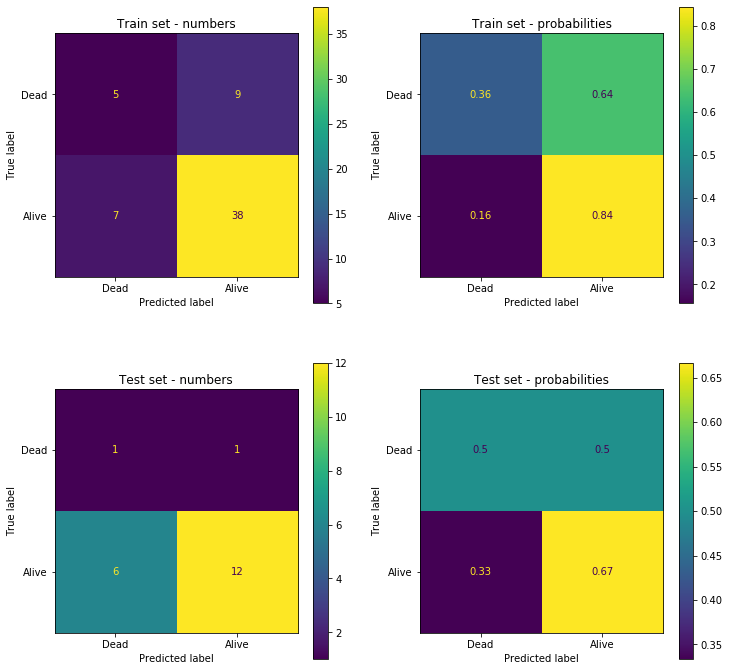

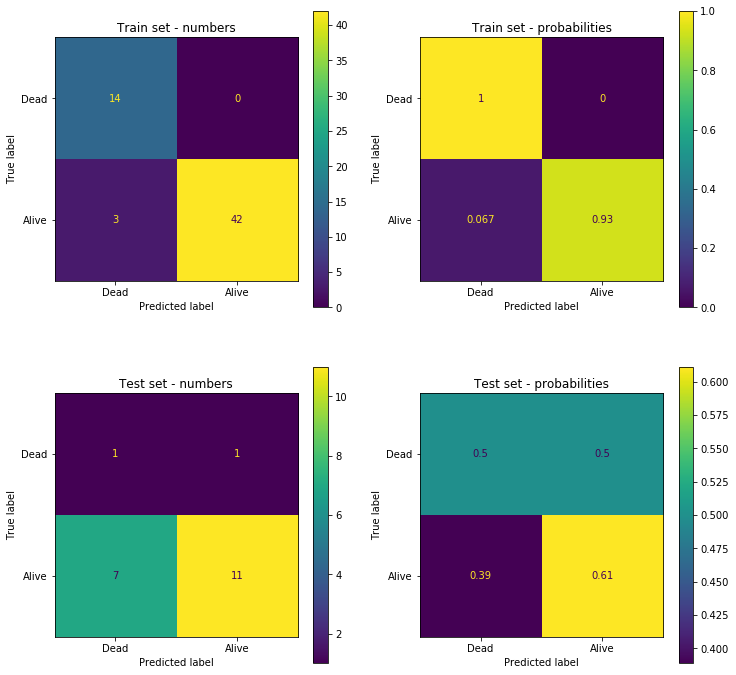

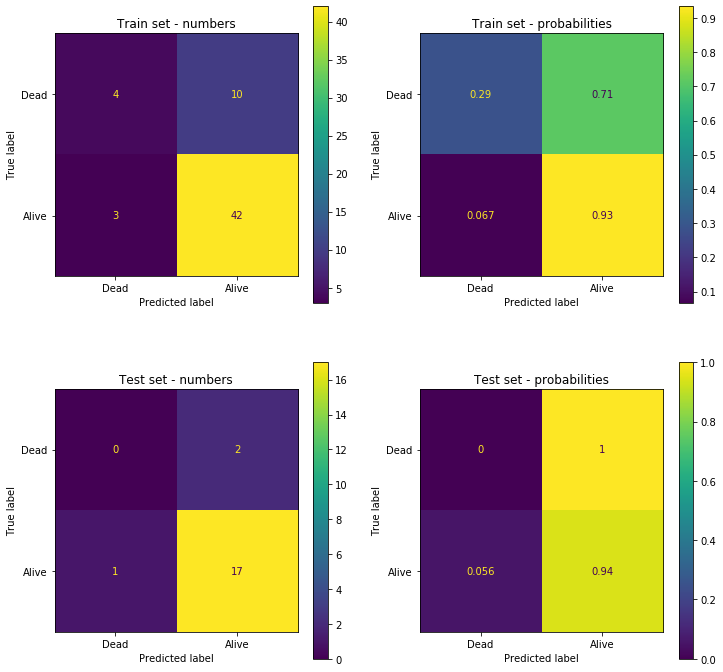

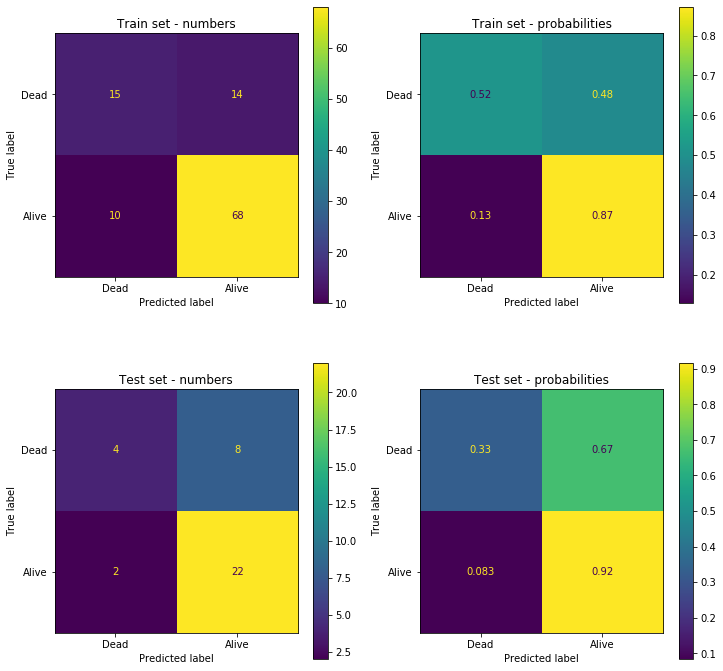

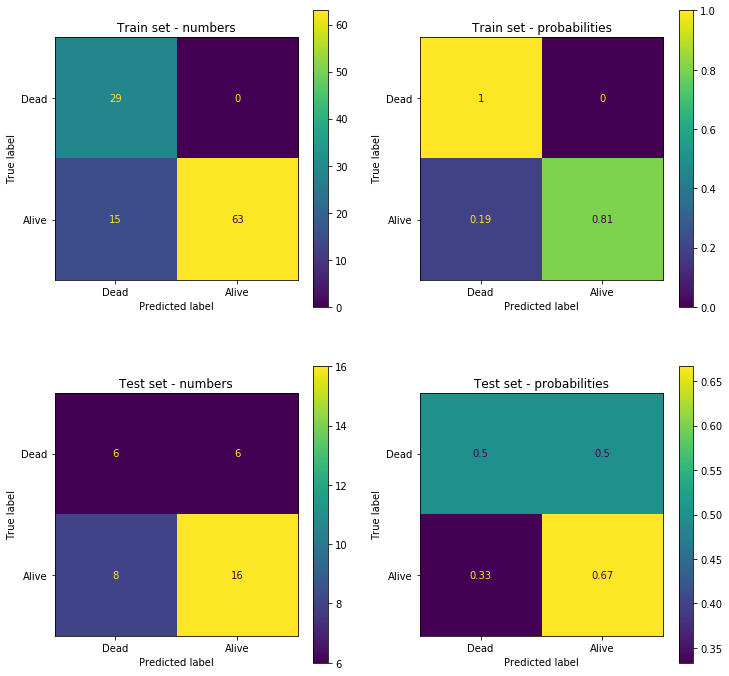

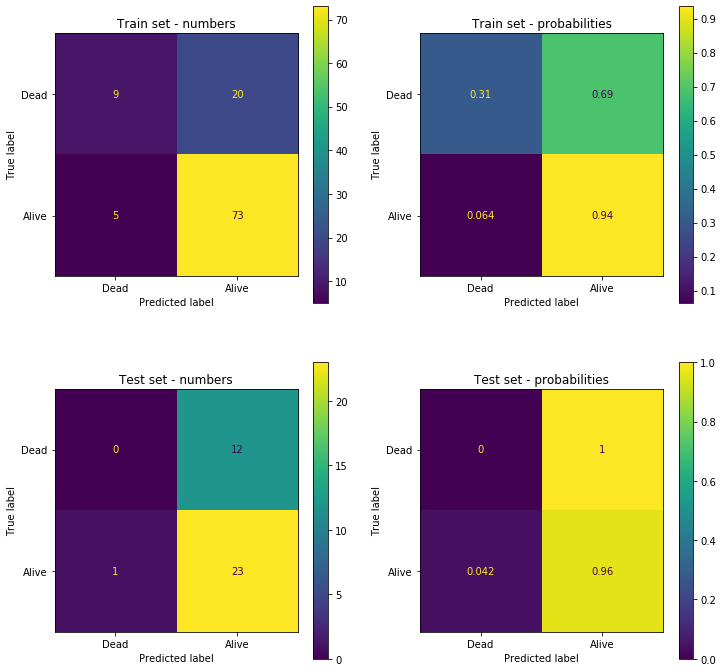

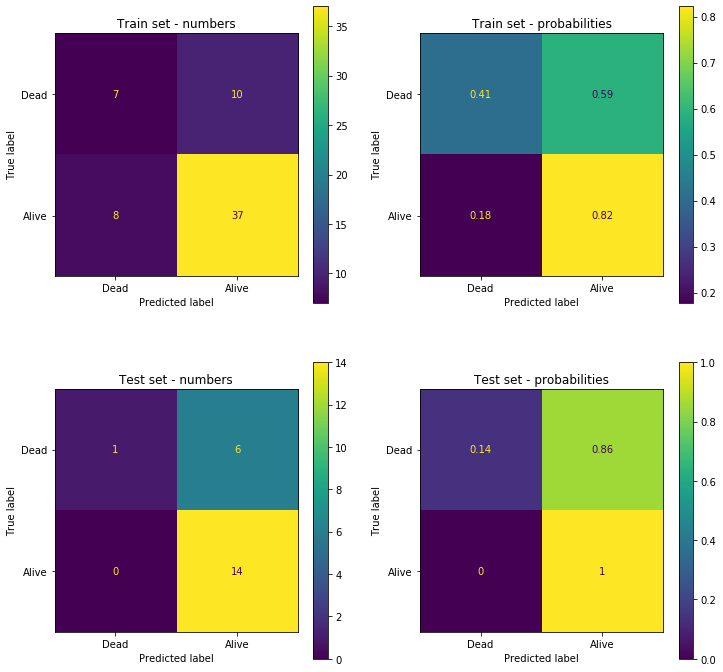

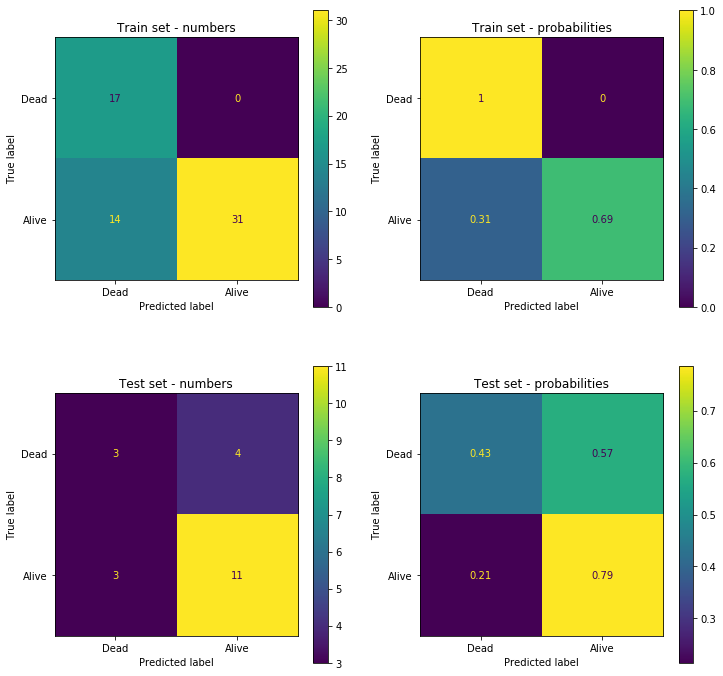

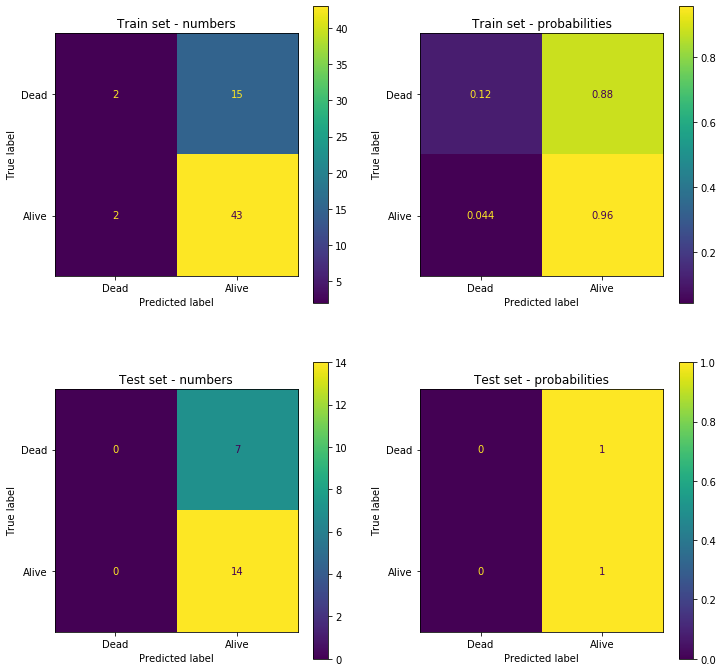

In [22]:
for i, frame in enumerate(frames):
    print("="*40)
    print(f" GROUP {i + 1} ".center(40, "="))
    print("="*40)

    x_i = frame[["Age", "Operation year", "Positive nodes"]]
    y_i = frame["Survival"]
    x_train_i, x_test_i, y_train_i, y_test_i = train_test_split(x_i, y_i)

    models = [nb.MultinomialNB(),
              KNeighborsClassifier(n_neighbors=2),
              LogisticRegression()]
    descriptions = ["Naive Bayes",
                    "KNN",
                    "Logistic Regression"]

    for mdl, desc in zip(models, descriptions):
        model = mdl.fit(x_train_i, y_train_i)
        print(f"{desc} classifier results:")
        summary(model,
                x_train_i, x_test_i,
                y_train_i, y_test_i)